In [3]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from matplotlib import pyplot as plt
%matplotlib inline 
xp = cuda.cupy
import time


def model_func(model):
    if xp == np:
        pass
    else :
        gpu_device = 0
        cuda.get_device(gpu_device).use()
        model.to_gpu(gpu_device)
xp.model_init = model_func
xp.pi = np.pi

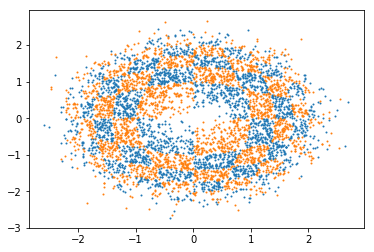

In [64]:
def mk_seq_dat(N=5000,_t = False,k=5):
    x = xp.random.randn(N,2,dtype=np.float32) * 2
    t = xp.where(x[:,0] % 2 > 1,0,1)
    t+= xp.where(x[:,1] % 2 > 1,0,1)
    x *= xp.linalg.norm(x,axis=1).reshape(-1,1) ** -0.5
    t %= 2
    t = t.astype(np.int32)
    if _t == True:
        x = xp.random.uniform(-k,k,(N,2)).astype(np.float32)
    return (x,t)
(dx,dt) = mk_seq_dat(5000,False)

cx = cuda.to_cpu(dx)
ct = cuda.to_cpu(dt)
plt.scatter(cx[:,0][ct==0],cx[:,1][ct==0],s=1)
plt.scatter(cx[:,0][ct==1],cx[:,1][ct==1],s=1)


In [58]:
def getMini(dx,dt,mN = 50):
    r = np.random.randint(dx.shape[0]//mN)
    return ( dx[r*mN:(r+1)*mN] , dt[r*mN:(r+1)*mN] )

In [59]:
class Path:
    def __init__(this,val):
        this.v = val
        
    def __call__(this,func = None):
        if func == None :
            return this.v
        else:
            return Path(func(this.v))
    def __str__(this):
        return "$"+str(this.v)
    
def add1(v):
    return v+1

def mul2(v):
    return v*2

a = Path(1)(add1)(add1)(mul2)(add1)(mul2)(add1)()
print (a)

15


In [60]:
def prt_shape(v):
    print (v.shape)
    return v

def RES(*p):
    def _(v):
        N = v.shape[0]
        tup = (N,) + p
        #print (v.shape)
        return F.reshape(v,tup)
    return _

def Add(v1):
    def _(v2):
        return v1 + v2
    return _

class PRD(Chain):
    def __init__(this):
        H = 12
        I = 32
        super().__init__(
            p1 = L.Linear(2,H),
            p2 = L.Linear(H,H),
            p3 = L.Linear(H,H),
            p4 = L.Linear(H,H),
            p5 = L.Linear(H,H),
            p6 = L.Linear(H,H),
            p7 = L.Linear(H,H),
            p8 = L.Linear(H,H),
            n1 = L.Linear(2,I),
            n2 = L.Linear(I,I),
            n3 = L.Linear(I,1),
            r1 = L.Linear(H,1),
            q1 = L.Linear(1,2),
        )
    def __call__(this,x,test = False):
        ac = F.absolute
        
        if 1 == 0:
            h = Path(x)(this.p1)(ac)(this.p2)(ac)(this.p3)(ac)(this.p4)(ac)(this.p5)(ac)(this.p6)(ac)()
            h = Path(h)(this.p7)(ac)(this.p8)(ac)()
            h = Path(h)(this.r1)(ac)()
        else:
            h = Path(x)(this.n1)(ac)()
            h = Path(h)(this.n2)(ac)(this.n2)(ac)(this.n2)(ac)(this.n2)(ac)(this.n2)(ac)(this.n2)(ac) \
                (this.n2)(ac)(this.n2)(ac)(this.n2)(ac)()
            h = Path(h)(this.n3)()
        
        q = h
        h = Path(h)(this.q1)()
        if test:
            return (h,q)
        else:
            return h
    
prd = PRD()
mdl = L.Classifier(prd)
xp.model_init(mdl)

opt = optimizers.Adam()
opt.setup(prd)
opt.add_hook(chainer.optimizer.WeightDecay(0.0001))

In [61]:
stp = 10000
prt = 500
losslist =[]

for i in range(stp):
    x,t = getMini(dx,dt,50)

    loss = mdl(x,t)
    
    prd.cleargrads()
    loss.backward()
    opt.update()
    
    if i % prt == 0:
        print (i,loss.data)
    losslist.append(cuda.to_cpu(loss.data))
losslist = np.array(losslist).reshape(-1)

0 0.6622210741043091
500 0.6970037817955017
1000 0.6787813305854797
1500 0.6583144068717957
2000 0.5161406397819519
2500 0.4151763916015625
3000 0.3746880292892456
3500 0.35382959246635437
4000 0.33888542652130127
4500 0.3170718252658844
5000 0.2625657916069031
5500 0.27456584572792053
6000 0.2767011523246765
6500 0.26806318759918213
7000 0.21781569719314575
7500 0.24981577694416046
8000 0.2460917979478836
8500 0.496052622795105
9000 0.27466925978660583
9500 0.33176422119140625


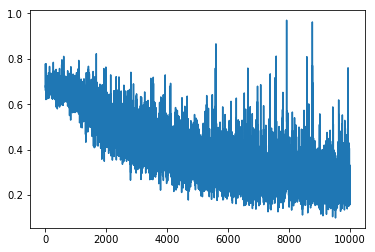

In [62]:
plt.plot(losslist)
plt.show()

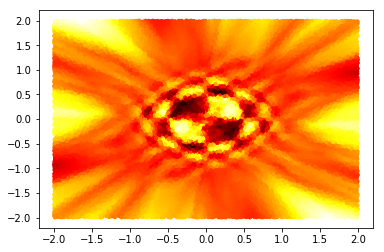

In [74]:
(ex,et) = mk_seq_dat(50000,True,k=2)

ey,q = prd(ex*2,True)

_dx = cuda.to_cpu(ex)
_dy = cuda.to_cpu(ey.data)
_dy = np.argmax(_dy,axis=1)
_q  = cuda.to_cpu(q.data).reshape(-1)

yy = 3

#plt.scatter(_dx[:,0][_dy==0],_dx[:,1][_dy==0],c=_q[_dy==0]*yy)
#plt.scatter(_dx[:,0][_dy==1],_dx[:,1][_dy==1],c=_q[_dy==1]*yy)

plt.scatter(_dx[:,0],_dx[:,1],c=_q*2,s=8,cmap="hot_r")
